# HackerEarth Deep Learning Beginner Challenge
Link : https://www.hackerearth.com/challenge/competitive/deep-learning-beginner-challenge/

## Environment Setup

Install and upgrade dependencies

In [1]:
#apt-get install p7zip-full
#pip3 install --upgrade pandas
#pip3 install --upgrade tensorflow

Download data and unzip to current directory


In [2]:
#mkdir Data
#wget -nc https://s3-ap-southeast-1.amazonaws.com/he-public-data/DL%23+Beginner.zip
#7z x "DL#+Beginner.zip" -aos
#7z x "DL# Beginner/meta-data.zip" -oData/ -aos
#7z x "DL# Beginner/test.zip" -oData/ -aos
#7z x "DL# Beginner/train.zip" -oData/ -aos

## Program

### Configure Imports

In [3]:
%matplotlib inline

import io
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
import sys
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import zipfile

tf.enable_eager_execution()

print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

C:\Program Files\Python 3.6.3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow version: 1.8.0
Eager execution: True


### Generate Dataset

### Build the Model

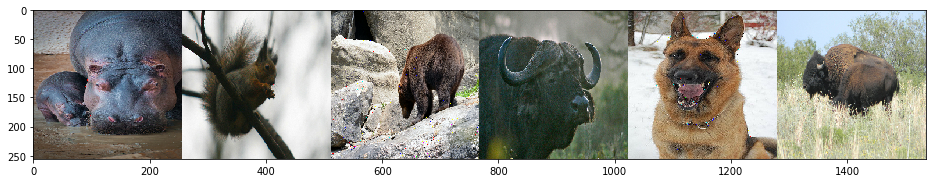

In [4]:
BATCH_SIZE = 256
IMAGE_SIZE = 256
# Generate the labels
animal_list = tf.constant(["antelope", "bat", "beaver", "bobcat", "buffalo",
               "chihuahua", "chimpanzee", "collie", "dalmatian", "german+shepherd",
               "grizzly+bear", "hippopotamus", "horse", "killer+whale", "mole",
               "moose", "mouse", "otter", "ox", "persian+cat",
               "raccoon", "rat", "rhinoceros", "seal", "siamese+cat",
               "spider+monkey", "squirrel", "walrus", "weasel", "wolf"])
classes_count = int(animal_list.shape[0])

def parseRawData(filename, label):
    # Get Image Data
    image_string = tf.read_file(filename)
    image_decoded = tf.image.decode_image(image_string, channels=3)
    image_decoded = tf.expand_dims(image_decoded, 0)
    image_resized = tf.image.resize_bicubic( image_decoded, [IMAGE_SIZE, IMAGE_SIZE])
    image_resized = tf.squeeze(image_resized)
    # Get one hot label
    one_hot_label = tf.one_hot(tf.argmax(tf.cast(tf.equal(label, animal_list), tf.int32), axis=0), 30)
    return image_resized, one_hot_label

df = pd.read_csv("Data/meta-data/train.csv")
train_files = tf.constant("Data/train/" + df['Image_id'].values)
train_labels = tf.constant(df['Animal'].values)
train_dataset = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
train_dataset = train_dataset.map(parseRawData)
train_dataset = train_dataset.batch(BATCH_SIZE)

iterator = train_dataset.make_one_shot_iterator()
batch_images, batch_labels = iterator.get_next()
plot_image = batch_images[0].numpy()
for i in range(1, 6):
    plot_image = np.concatenate((plot_image, batch_images[i]), axis=1)
plt.rcParams["axes.grid"] = False
plt.rcParams["figure.figsize"] = (16,8)
plt.imshow(plot_image.astype('B'))

In [5]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters=8, kernel_size=(11, 11), strides=(2, 2), activation='relu', padding="same", input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(7, 7), strides=(2, 2), activation='relu', padding="same"))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), strides=(2, 2), activation='relu', padding="same"))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), strides=(2, 2), activation='relu', padding="same"))
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding="same"))
model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding="same"))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(classes_count))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 8)       2912      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        6288      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        12832     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        51264     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
__________

In [6]:
def loss(model, x, y):
    y_ = model(x)
    return tf.losses.softmax_cross_entropy(onehot_labels=y, logits=y_)

def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return tape.gradient(loss_value, model.variables)

In [15]:
train_loss_results = []
train_accuracy_results = []

optimizer = tf.train.AdamOptimizer()
num_epochs = 20

for epoch in range(num_epochs):
    print("Epoch {:d}".format(epoch))
    # Training loop - using batches of 32
    for x, y in train_dataset:
        # Optimize the model
        grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.variables), global_step=tf.train.get_or_create_global_step())

        batch_loss = loss(model, x, y)
        batch_accuracy = tf.reduce_mean( tf.cast(tf.equal(tf.argmax(model(x), axis=1), tf.argmax(y, axis=1)), tf.float32) )

        print("Loss: {:.3f}, Accuracy: {:.3%}".format(batch_loss, batch_accuracy))
        train_loss_results.append(batch_loss)
        train_accuracy_results.append(batch_accuracy)
print("Done")

Epoch 0
Loss: 3.553, Accuracy: 22.266%
Loss: 2.782, Accuracy: 22.266%
Loss: 2.559, Accuracy: 25.391%
Loss: 2.828, Accuracy: 18.750%
Loss: 2.742, Accuracy: 23.047%
Loss: 2.818, Accuracy: 26.172%
Loss: 2.832, Accuracy: 23.047%
Loss: 2.913, Accuracy: 23.438%
Loss: 2.798, Accuracy: 25.000%
Loss: 2.789, Accuracy: 20.703%
Loss: 2.668, Accuracy: 26.562%
Loss: 2.803, Accuracy: 19.141%
Loss: 2.769, Accuracy: 21.094%
Loss: 2.703, Accuracy: 23.828%
Loss: 2.742, Accuracy: 23.047%
Loss: 2.568, Accuracy: 24.219%
Loss: 2.562, Accuracy: 24.219%
Loss: 2.525, Accuracy: 27.734%
Loss: 2.588, Accuracy: 26.953%
Loss: 2.546, Accuracy: 27.734%
Loss: 2.585, Accuracy: 31.250%
Loss: 2.401, Accuracy: 30.078%
Loss: 2.468, Accuracy: 30.859%
Loss: 2.494, Accuracy: 29.297%
Loss: 2.465, Accuracy: 28.906%
Loss: 2.385, Accuracy: 34.766%
Loss: 2.549, Accuracy: 27.344%
Loss: 2.309, Accuracy: 33.594%
Loss: 2.435, Accuracy: 32.031%
Loss: 2.394, Accuracy: 29.688%
Loss: 2.404, Accuracy: 32.031%
Loss: 2.227, Accuracy: 32.031%


Loss: 1.266, Accuracy: 63.281%
Loss: 1.260, Accuracy: 62.891%
Loss: 1.172, Accuracy: 63.281%
Loss: 1.221, Accuracy: 64.844%
Loss: 1.122, Accuracy: 69.922%
Loss: 1.087, Accuracy: 67.969%
Loss: 1.230, Accuracy: 64.844%
Loss: 1.006, Accuracy: 72.656%
Loss: 1.014, Accuracy: 67.969%
Loss: 0.941, Accuracy: 73.438%
Loss: 1.086, Accuracy: 69.922%
Loss: 1.092, Accuracy: 73.047%
Loss: 0.981, Accuracy: 69.531%
Loss: 1.044, Accuracy: 68.359%
Loss: 1.108, Accuracy: 69.141%
Loss: 1.084, Accuracy: 67.969%
Loss: 1.286, Accuracy: 63.672%
Loss: 1.063, Accuracy: 67.578%
Loss: 1.060, Accuracy: 65.234%
Loss: 0.918, Accuracy: 76.953%
Loss: 0.961, Accuracy: 70.312%
Loss: 1.043, Accuracy: 67.578%
Loss: 1.089, Accuracy: 67.578%
Loss: 1.000, Accuracy: 71.875%
Loss: 0.991, Accuracy: 70.703%
Loss: 1.004, Accuracy: 70.703%
Loss: 1.058, Accuracy: 69.531%
Loss: 0.865, Accuracy: 75.781%
Loss: 0.865, Accuracy: 76.172%
Loss: 0.769, Accuracy: 80.078%
Loss: 0.744, Accuracy: 77.734%
Loss: 0.716, Accuracy: 80.078%
Loss: 0.

Loss: 0.387, Accuracy: 87.500%
Loss: 0.337, Accuracy: 89.453%
Loss: 0.370, Accuracy: 89.062%
Loss: 0.360, Accuracy: 91.797%
Loss: 0.397, Accuracy: 87.891%
Loss: 0.469, Accuracy: 87.109%
Loss: 0.479, Accuracy: 88.672%
Loss: 0.389, Accuracy: 91.016%
Loss: 0.348, Accuracy: 92.188%
Loss: 0.362, Accuracy: 91.016%
Loss: 0.318, Accuracy: 93.750%
Loss: 0.386, Accuracy: 91.406%
Loss: 0.302, Accuracy: 93.750%
Loss: 0.338, Accuracy: 91.016%
Loss: 0.366, Accuracy: 87.891%
Loss: 0.291, Accuracy: 91.406%
Loss: 0.303, Accuracy: 92.578%
Loss: 0.315, Accuracy: 93.359%
Loss: 0.280, Accuracy: 92.969%
Loss: 0.269, Accuracy: 94.531%
Loss: 0.278, Accuracy: 93.359%
Loss: 0.275, Accuracy: 93.359%
Loss: 0.363, Accuracy: 89.844%
Loss: 0.369, Accuracy: 90.625%
Loss: 0.439, Accuracy: 86.328%
Loss: 0.299, Accuracy: 92.188%
Loss: 0.323, Accuracy: 90.234%
Loss: 0.187, Accuracy: 96.094%
Loss: 0.212, Accuracy: 93.750%
Loss: 0.378, Accuracy: 87.500%
Loss: 0.261, Accuracy: 91.797%
Loss: 0.240, Accuracy: 93.750%
Loss: 0.

Loss: 0.112, Accuracy: 97.656%
Loss: 0.065, Accuracy: 99.219%
Loss: 0.128, Accuracy: 96.484%
Loss: 0.170, Accuracy: 95.703%
Loss: 0.200, Accuracy: 94.922%
Loss: 0.193, Accuracy: 92.969%
Loss: 0.114, Accuracy: 98.047%
Loss: 0.097, Accuracy: 98.438%
Loss: 0.167, Accuracy: 94.531%
Loss: 0.161, Accuracy: 96.094%
Loss: 0.288, Accuracy: 91.797%
Loss: 0.268, Accuracy: 92.188%
Loss: 0.177, Accuracy: 96.094%
Loss: 0.114, Accuracy: 98.438%
Loss: 0.165, Accuracy: 94.922%
Loss: 0.173, Accuracy: 93.750%
Loss: 0.272, Accuracy: 91.797%
Loss: 0.230, Accuracy: 92.578%
Loss: 0.242, Accuracy: 95.312%
Loss: 0.236, Accuracy: 94.922%
Loss: 0.202, Accuracy: 95.312%
Loss: 0.238, Accuracy: 94.141%
Loss: 0.172, Accuracy: 95.312%
Loss: 0.180, Accuracy: 96.875%
Loss: 0.196, Accuracy: 95.312%
Loss: 0.179, Accuracy: 95.703%
Loss: 0.080, Accuracy: 99.000%
Epoch 16
Loss: 0.169, Accuracy: 96.875%
Loss: 0.118, Accuracy: 98.438%
Loss: 0.119, Accuracy: 97.656%
Loss: 0.185, Accuracy: 95.312%
Loss: 0.110, Accuracy: 97.656%

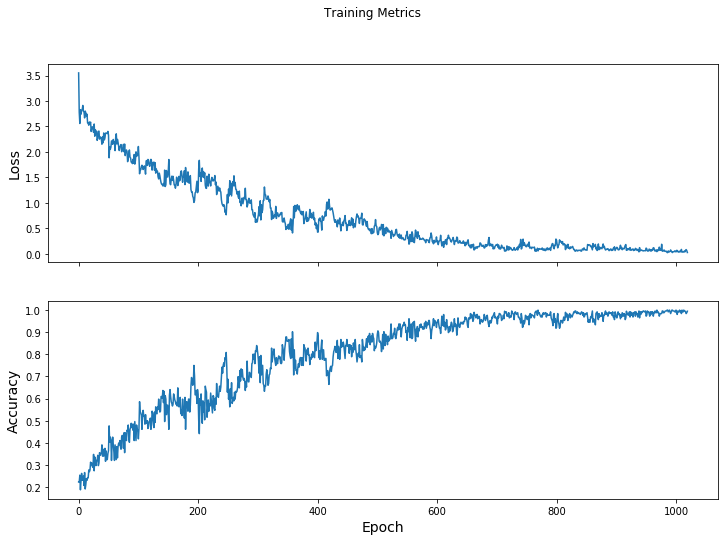

In [16]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)


plt.show()

### Make Prediction

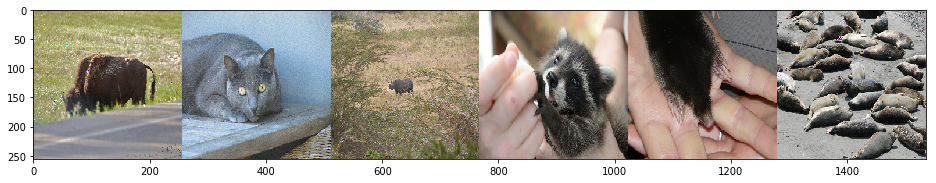

In [47]:
def parseTestData(filename):
    # Get Image Data
    image_string = tf.read_file(filename)
    image_decoded = tf.image.decode_image(image_string, channels=3)
    image_decoded = tf.expand_dims(image_decoded, 0)
    image_resized = tf.image.resize_bicubic( image_decoded, [IMAGE_SIZE, IMAGE_SIZE])
    image_resized = tf.squeeze(image_resized)
    return image_resized

df_test = pd.read_csv("Data/meta-data/test.csv")
test_files = tf.constant("Data/test/" + df_test['Image_id'].values)
test_dataset = tf.data.Dataset.from_tensor_slices(test_files)
test_dataset = test_dataset.map(parseTestData)
test_dataset = test_dataset.batch(BATCH_SIZE)

iterator = test_dataset.make_one_shot_iterator()
batch_images = iterator.get_next()
plot_image = batch_images[0].numpy()
for i in range(1, 6):
    plot_image = np.concatenate((plot_image, batch_images[i]), axis=1)
plt.rcParams["axes.grid"] = False
plt.rcParams["figure.figsize"] = (16,8)
plt.imshow(plot_image.astype('B'))

In [51]:
#Prepare Pandas Data Frame
print(type(animal_list.numpy()))
for animal in animal_list.numpy():
    df_test[animal.decode('ascii')] = 0
df_test.head(10)

<class 'numpy.ndarray'>


,Image_id,antelope,bat,beaver,bobcat,buffalo,chihuahua,chimpanzee,collie,dalmatian,...,raccoon,rat,rhinoceros,seal,siamese+cat,spider+monkey,squirrel,walrus,weasel,wolf
0,Img-1.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Img-2.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Img-3.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Img-4.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Img-5.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Img-6.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Img-7.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Img-8.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Img-9.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Img-10.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
i = 0
for x in test_dataset:
    # Optimize the model
    y_logits = model(x)
    prob_batch = tf.nn.softmax(y_logits)
    print(i)
    for prob in prob_batch.numpy():
        for j,val in enumerate(prob):
            df_test.iloc[i,j+1] = val
        i+=1
    prediction_values.append(prob)

print(prediction_values)

0
256
512
768
1024
1280
1536
1792
2048
2304
2560
2816
3072
3328
3584
3840
4096
4352
4608
4864
5120
5376
5632
5888
[<tf.Tensor: id=546748, shape=(256, 30), dtype=float32, numpy=
array([[7.65303280e-14, 1.15134744e-05, 5.72871178e-13, ...,
        1.36781589e-03, 4.99393771e-09, 9.98256862e-01],
       [2.10589111e-08, 4.01712343e-04, 1.58347022e-02, ...,
        8.46096314e-03, 1.04917926e-04, 3.93751679e-06],
       [2.54515633e-02, 5.87869590e-06, 9.05257821e-01, ...,
        1.17723075e-05, 8.01550166e-04, 1.63538280e-04],
       ...,
       [6.03811945e-10, 1.58573640e-10, 2.04733830e-09, ...,
        3.89807103e-14, 7.84241005e-10, 1.04922962e-14],
       [1.48760824e-04, 8.29953422e-07, 2.57746500e-08, ...,
        2.58255899e-11, 2.07980039e-11, 2.93126519e-08],
       [1.01413811e-08, 4.60997143e-07, 1.04156095e-09, ...,
        4.76286210e-09, 9.29863018e-06, 4.60066713e-06]], dtype=float32)>, <tf.Tensor: id=546802, shape=(256, 30), dtype=float32, numpy=
array([[9.6918666e-07, 

In [55]:
df_test.head(10)

,Image_id,antelope,bat,beaver,bobcat,buffalo,chihuahua,chimpanzee,collie,dalmatian,...,raccoon,rat,rhinoceros,seal,siamese+cat,spider+monkey,squirrel,walrus,weasel,wolf
0,Img-1.jpg,7.653033e-14,1.151347e-05,5.728712e-13,6.656555e-07,2.256825e-09,5.026594e-08,2.963739e-10,4.680986e-08,1.460929e-16,...,7.752319e-10,8.252430e-13,1.186331e-04,6.340278e-11,3.849354e-10,6.839430e-13,3.536147e-14,1.367816e-03,4.993938e-09,9.982569e-01
1,Img-2.jpg,2.105891e-08,4.017123e-04,1.583470e-02,2.367927e-06,1.821038e-07,2.148638e-03,1.176559e-06,1.647605e-05,5.304312e-10,...,2.664462e-05,2.066276e-02,3.962302e-05,8.314557e-04,3.851462e-04,1.822821e-05,9.265344e-01,8.460963e-03,1.049179e-04,3.937517e-06
2,Img-3.jpg,2.545156e-02,5.878696e-06,9.052578e-01,2.784178e-06,3.426685e-04,2.559011e-05,7.177659e-06,2.573904e-05,1.660285e-07,...,6.254122e-06,1.074550e-03,1.275948e-06,9.888280e-05,2.433672e-05,2.006360e-03,2.208504e-03,1.177231e-05,8.015502e-04,1.635383e-04
3,Img-4.jpg,6.545994e-09,2.617925e-16,5.487227e-10,1.201974e-18,2.351675e-09,4.467221e-07,1.624314e-11,8.755153e-08,1.013547e-07,...,8.435158e-13,1.239034e-14,3.285755e-17,1.060474e-14,7.152169e-12,1.149791e-12,8.292082e-10,7.846998e-21,4.337239e-24,1.230805e-21
4,Img-5.jpg,3.534521e-03,4.723824e-05,8.614837e-03,3.083206e-08,1.919875e-01,1.065157e-04,4.391612e-06,1.127806e-02,1.216074e-05,...,3.842674e-06,4.099410e-04,3.408045e-05,1.049751e-01,2.011585e-02,1.317665e-04,6.530822e-04,3.625311e-04,2.709707e-06,6.281291e-07
5,Img-6.jpg,1.505878e-08,2.631589e-03,9.921359e-10,1.736050e-04,5.718322e-11,1.211662e-06,3.898655e-01,9.744833e-03,3.323165e-09,...,2.012080e-01,5.275324e-08,4.279172e-09,1.671590e-01,6.325630e-09,9.550888e-07,9.163978e-08,3.957654e-03,4.170624e-05,7.967569e-04
6,Img-7.jpg,2.457337e-02,1.515961e-05,5.597205e-06,2.078852e-04,1.913164e-03,2.779745e-03,5.942642e-05,6.490971e-06,9.799055e-06,...,9.572312e-05,3.705784e-06,6.225505e-04,6.687549e-07,4.536243e-05,1.097041e-04,9.408122e-01,1.695988e-08,1.496929e-04,1.366001e-04
7,Img-8.jpg,1.579965e-08,8.326852e-12,5.435622e-08,1.538096e-12,4.844014e-11,7.464839e-01,1.333956e-05,2.433880e-05,1.617831e-06,...,1.273364e-09,2.131782e-07,6.456468e-14,6.045428e-13,1.186384e-04,2.501323e-07,1.741421e-10,1.735214e-11,2.063400e-13,5.406219e-07
8,Img-9.jpg,6.357503e-13,3.290070e-08,2.104191e-12,3.497752e-10,2.404654e-07,1.728017e-12,2.938032e-08,3.989331e-12,7.282542e-15,...,1.034549e-13,8.897716e-13,9.180189e-03,2.091131e-09,1.809198e-06,1.736240e-12,2.628190e-05,2.333003e-13,1.018654e-13,7.266222e-12
9,Img-10.jpg,8.946409e-09,7.015934e-12,8.014743e-19,7.717576e-15,4.815145e-17,1.332056e-07,2.078336e-13,6.109738e-01,3.890258e-01,...,1.847763e-09,1.476413e-15,9.996822e-21,3.945817e-21,1.774914e-20,1.155336e-16,1.920246e-20,2.876479e-27,6.906247e-14,1.462947e-22


In [56]:
df_test.to_csv('predictions.csv', sep=',', encoding='utf-8')